## Домашнее задание
Практический проект по построению системы поиска аномалий.
Цель: В этом домашнем задании вы попробуете найти патологии в электрокардиографии плода. В датасете, собранном университетом Порто (Португалия), есть не так много наблюдений с патологиями, поэтому имеет смысл попробовать поиск аномалий, а не только классификацию.
1. Возьмите данные по электрокардиографии плода (файл cardio.mat в материалах) и загрузите их в питон при помощи следующих манипуляций:

import pandas as pd
import scipy.io
data= scipy.io.loadmat('cardio.mat')

X = pd.DataFrame(data['X'])
y = pd.DataFrame(data['y'])

2. Используйте все измерения X для построения алгоритмов поиска аномалий, которые умеют работать с "загрязненными" данными (DBSCAN, Isolation Forest). Для настройки гиперпараметров моделей, используйте процент аномалий равный 9.6%

3. При помощи разметки y, постройте confusion_matrix для предсказаний вашей модели по всем данным

4. Теперь возьмите подвыборку измерений X, в которой y==0 ("чистые данные") и постройте алгоритмы, которые умеют работать только с чистыми данными (Distance-based методы, One Class SVM)

5. Аналогично постройте confusion_matrix для предсказаний вашей модели на всех данных

6. Бонус - попробуйте любые supervised методы для предсказания патологии сердца (для этого сделайте стратифицированный train_test_split, отложив 20% наблюдений для тестирования). Постройте confusion_matrix для тренировочной и тестовой части выборки.

Какие методы сработали лучше?
Критерии оценки: - Построены алгоритмы для "загрязненных данных" + 5 баллов
- Построены алгоритмы для "чистых данных" + 5 баллов
- Бонус + 4 балла

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from pandas.tools.plotting import table

%matplotlib inline

In [2]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

In [3]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

In [4]:
import scipy.io

## Знакомство с данными

In [5]:
df= scipy.io.loadmat('data/cardio.mat')

X = pd.DataFrame(df['X'])
y = pd.DataFrame(df['y'])

In [6]:
print('Размер выборки:', X.shape) #check size
X.head( )

Размер выборки: (1831, 21)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.004912,0.693191,-0.203640,0.595322,0.353190,-0.061401,-0.278295,-1.650444,0.759072,-0.420487,...,1.485973,-0.798376,1.854728,0.622631,0.963083,0.301464,0.193113,0.231498,-0.289786,-0.493294
1,0.110729,-0.079903,-0.203640,1.268942,0.396246,-0.061401,-0.278295,-1.710270,0.759072,-0.420487,...,1.485973,-0.798376,1.854728,0.278625,0.963083,0.301464,0.129265,0.093563,-0.256385,-0.493294
2,0.216546,-0.272445,-0.203640,1.050988,0.148753,-0.061401,-0.278295,-1.710270,1.106509,-0.420487,...,1.141780,-1.332931,0.314688,2.342663,-0.488279,0.061002,0.065417,0.024596,-0.256385,1.140018
3,0.004912,0.727346,-0.203640,1.212171,-0.683598,-0.061401,-0.278295,-1.710270,1.106509,-0.420487,...,1.141780,-1.332931,0.314688,1.654650,-0.488279,0.061002,0.193113,0.093563,-0.323186,1.140018
4,-0.100905,0.363595,1.321366,1.027120,0.141359,-0.061401,-0.278295,-0.992364,-0.051613,-0.420487,...,-0.208514,-0.085638,-0.565334,0.278625,-0.488279,-0.059229,0.065417,0.024596,-0.456787,1.140018


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1831 entries, 0 to 1830
Data columns (total 21 columns):
0     1831 non-null float64
1     1831 non-null float64
2     1831 non-null float64
3     1831 non-null float64
4     1831 non-null float64
5     1831 non-null float64
6     1831 non-null float64
7     1831 non-null float64
8     1831 non-null float64
9     1831 non-null float64
10    1831 non-null float64
11    1831 non-null float64
12    1831 non-null float64
13    1831 non-null float64
14    1831 non-null float64
15    1831 non-null float64
16    1831 non-null float64
17    1831 non-null float64
18    1831 non-null float64
19    1831 non-null float64
20    1831 non-null float64
dtypes: float64(21)
memory usage: 300.5 KB


In [8]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
count,1.831000e+03,1.831000e+03,1.831000e+03,1.831000e+03,1.831000e+03,1.831000e+03,1.831000e+03,1.831000e+03,1.831000e+03,1.831000e+03,...,1.831000e+03,1.831000e+03,1.831000e+03,1.831000e+03,1.831000e+03,1.831000e+03,1.831000e+03,1.831000e+03,1.831000e+03,1.831000e+03
mean,1.144603e-15,9.408094e-16,8.313636e-16,-1.566682e-15,-2.365970e-15,-8.702229e-16,-4.825923e-15,-6.424862e-16,-2.267256e-15,-1.048072e-15,...,1.905448e-16,1.319413e-16,8.289989e-16,5.525649e-16,1.119925e-16,-3.283980e-16,-3.771484e-16,4.717387e-16,1.244226e-16,-1.173526e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.746331e+00,-9.199884e-01,-2.036405e-01,-1.635871e+00,-6.835985e-01,-6.140064e-02,-2.782949e-01,-1.949572e+00,-1.441358e+00,-4.204873e-01,...,-1.876524e+00,-1.439841e+00,-2.325379e+00,-1.441408e+00,-4.882789e-01,-4.567897e+00,-3.829316e+00,-4.113439e+00,-6.905897e-01,-2.126605e+00
25%,-7.358069e-01,-9.199884e-01,-2.036405e-01,-7.425390e-01,-6.835985e-01,-6.140064e-02,-2.782949e-01,-8.727134e-01,-7.464856e-01,-4.204873e-01,...,-8.704229e-01,-9.052873e-01,-6.753367e-01,-7.533948e-01,-4.882789e-01,-5.401537e-01,-5.730636e-01,-6.650764e-01,-5.903887e-01,-4.932940e-01
50%,4.912315e-03,-2.872966e-01,-2.036405e-01,2.691593e-02,-6.835985e-01,-6.140064e-02,-2.782949e-01,-3.515685e-02,-1.674248e-01,-4.204873e-01,...,-2.317947e-02,-5.000071e-02,-7.032128e-02,-6.538189e-02,-4.882789e-01,8.864667e-04,6.541726e-02,2.459619e-02,-3.899867e-01,-4.932940e-01
75%,6.398145e-01,6.604231e-01,-1.605488e-01,7.200708e-01,5.243316e-01,-6.140064e-02,-2.782949e-01,8.023997e-01,4.116360e-01,-1.715262e-01,...,7.446349e-01,8.765597e-01,5.896955e-01,6.226310e-01,-4.882789e-01,6.621578e-01,7.038981e-01,7.142687e-01,1.778189e-01,1.140018e+00
max,2.967789e+00,3.956212e+00,9.929345e+00,3.584122e+00,4.316910e+00,1.990039e+01,8.587322e+00,2.537338e+00,6.433868e+00,5.243379e+00,...,2.809791e+00,2.444585e+00,4.054783e+00,4.750709e+00,1.402534e+01,3.066781e+00,3.130125e+00,3.403992e+00,8.294100e+00,1.140018e+00


In [9]:
# finding nulls
X.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
dtype: int64

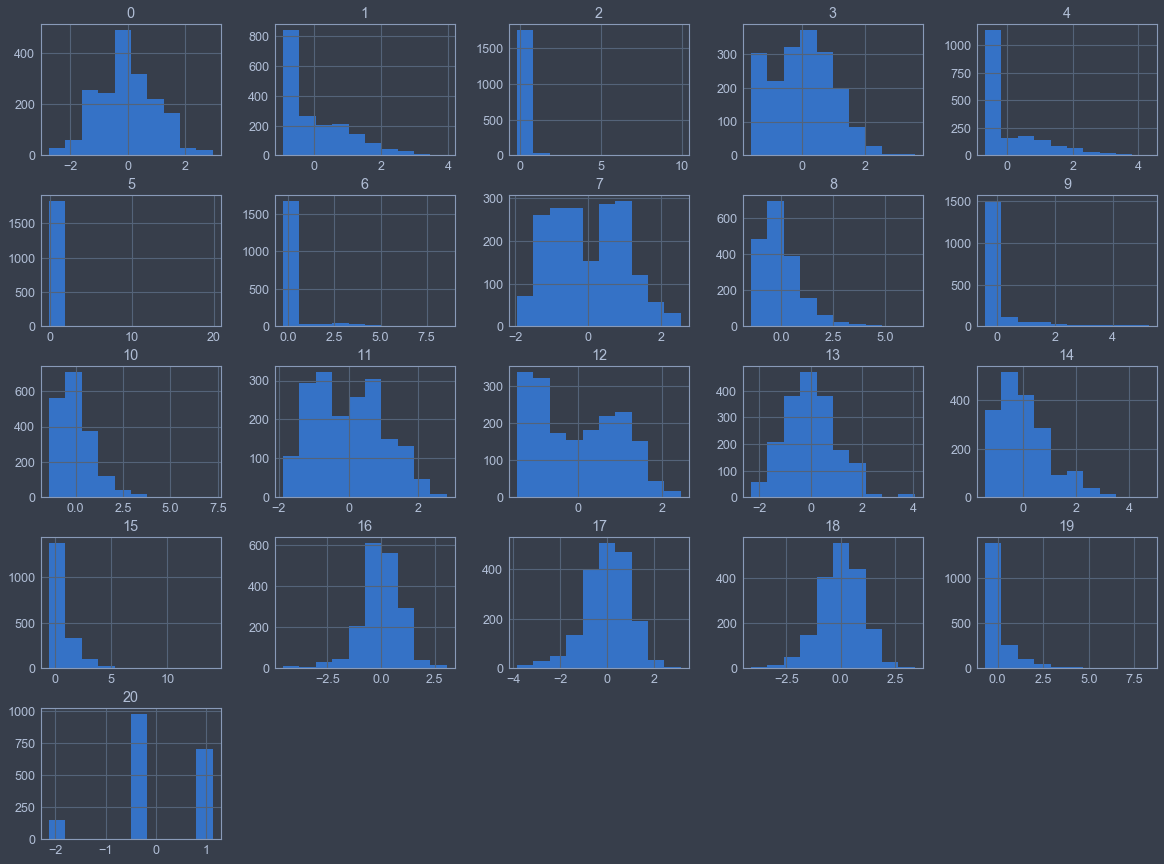

In [10]:
X.hist(figsize=(20, 15));

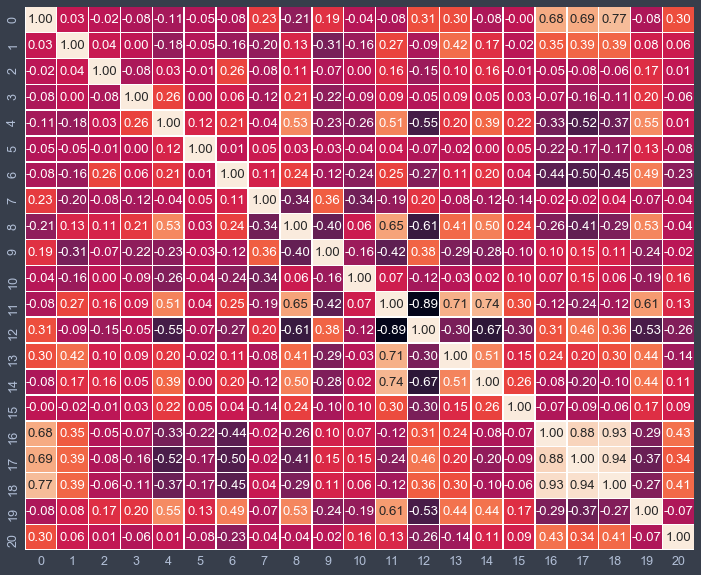

In [11]:
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

итак, признаки 16,17,18 сильно коррелированы между собой, да и признаков много как-то, поэтому...

### Уменьшение размерности

на этом этапе, я хочу уменьшить размерность, чтобы мне легче было определить локоть в инерции. Так я буду знать, сколько у нас всего кластеров

In [12]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [13]:
# Standardize data
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

# Normalizing the Data
normalized_X = normalize(scaled_X)

# Converting the numpy array into a pandas DataFrame
normalized_X = pd.DataFrame(normalized_X)

In [14]:
def analyzePCA(X, pca, explained_threshold=0.95):
    """Plot cumulative explaned variance of PCA"""
    pca.fit(X)
    pca_variance = pca.explained_variance_ratio_
    plt.figure(figsize=(15,7))
    plt.plot(np.cumsum(pca_variance))
    plt.hlines(explained_threshold, 0, len(pca_variance))
    plt.title("Number of components to explain {}% of variance: {}".format(
        100*explained_threshold, np.argwhere(np.cumsum(pca_variance)>0.95)[0]
    ))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');

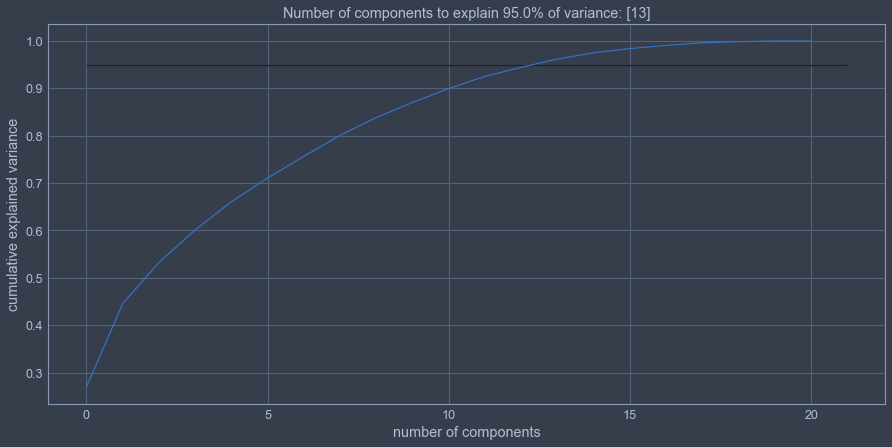

In [15]:
pca = PCA()
analyzePCA(scaled_X, pca)

итак, нам достаточно 12-13 признаков

In [16]:
x_new = PCA(n_components=13).fit_transform(scaled_X)
x_new.shape

(1831, 13)

In [17]:
normalized_x_new = normalize(x_new)

## DBScan

In [72]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.602, min_samples=6).fit(normalized_X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: {}'.format(n_clusters_))
print('Estimated percentage of noise points: {:.2f}%'.format(100*n_noise_/normalized_X.shape[0]))

Estimated number of clusters: 4
Estimated percentage of noise points: 9.67%


In [73]:
predicted_labels = np.array([1 if label == -1 else 0 for label in db.labels_])

In [74]:
unique, counts = np.unique(predicted_labels, return_counts=True)
dict(zip(unique, counts))

{0: 1654, 1: 177}

In [75]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{-1: 177, 0: 1636, 1: 6, 2: 5, 3: 7}

In [76]:
y[0].value_counts()

0.0    1655
1.0     176
Name: 0, dtype: int64

In [27]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=50)

tsne_transformed = tsne.fit_transform(normalized_X)

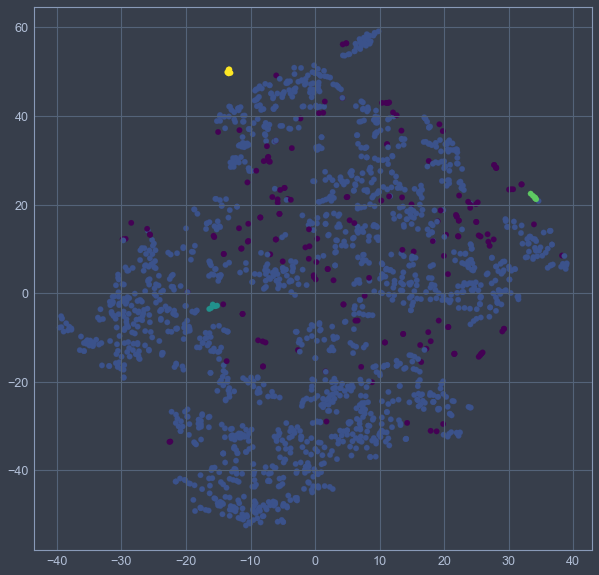

In [77]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=db.labels_);

In [81]:
inertia = []
k = range(1, 10)
for k_i in k:
    km = KMeans(n_clusters=k_i).fit(normalized_x_new)
    inertia.append(km.inertia_)

figure(figsize=(10, 6))
plt.plot(k, inertia, color='orange')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal k');

NameError: name 'figure' is not defined

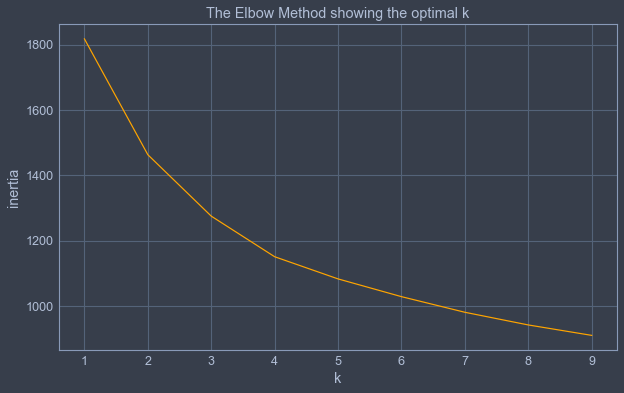

In [80]:
inertia = []
k = range(1, 10)
for k_i in k:
    km = KMeans(n_clusters=k_i).fit(normalized_X)
    inertia.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k, inertia, color='orange')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal k');

итак, я бы сказал, что локоть отчетливый на 4 кластерах, так что под DBScan мы выбрали более-менее параметры

In [64]:
def plot_confusion(true_labels, preds):
    cm = confusion_matrix(true_labels, preds)
    conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted: 0','Predicted: 1'], index=['Actual: 0','Actual: 1'])
    plt.figure(figsize = (5,5))
    sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

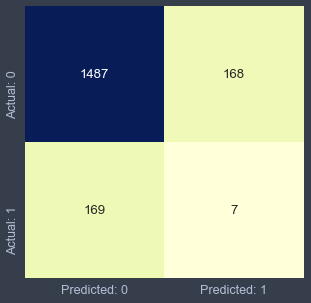

In [65]:
plot_confusion(y, predicted_labels)

<img src="img/fire.jpeg">

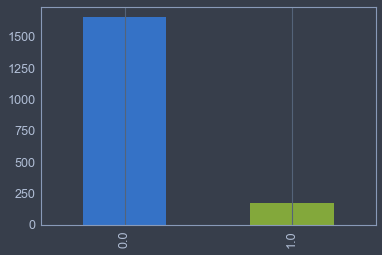

In [31]:
y[0].value_counts().plot.bar(figsize=(6, 4))
plt.grid(axis='y')

In [32]:
y[0].value_counts(normalize=True)

0.0    0.903878
1.0    0.096122
Name: 0, dtype: float64